## 1. Setup: Connect to Dask Cluster

Astroflow provides access to distributed computing resources. This cluster has:
- 700 GB memory
- 10 worker processes
- 50 threads
  
Plenty to compute with!

In [ ]:
# Do the imports
from dask.distributed import Client
import dask.dataframe as dd
import seaborn as sns
import time
import dask
import numpy as np
import healpy as hp
import matplotlib.pyplot as plot
import math
from pathlib import Path
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Set up the client
c = Client('tcp://simple-scheduler.dask-operator.svc.cluster.local:8786')
print(c)

## 2. Load Gaia DR3 Data

We read directly from the parquet files on the server's SSD storage. 
No download required - data stays on the server.

- Load gaiadr3.gaia_source

In [2]:
required_columns = [
    'source_id', 
    'ra',
    'dec',
    'pmra',
    'pmra_error',
    'pmdec',
    'pmdec_error',
    'pmra_pmdec_corr',
    'parallax',
    'parallax_over_error',
    'radial_velocity',
    'radial_velocity_error',
    'ruwe'
]

df = dd.read_parquet(Path(os.environ['DASK_DATA_PATH_GAIA_DR3_SSD']).joinpath("GDR3_GAIA_SOURCE"), columns=required_columns)


## 3. Filter to 6D Sample

Apply quality cuts:
- `ruwe < 1.4` (good astrometric solution)
- Radial velocity measured
- `parallax_over_error > 5`

In [3]:
#now filter the DF to keep only stars with 6D information..
df6d = df[df['radial_velocity'].notnull()
    & (df['ruwe'] < 1.4)
    & (df['parallax_over_error'] > 5)]
df6d = df6d.assign(distance=1.0 / df6d['parallax'])  # distance in kpc
#Assign distnaces as 1/ parallax, although originally I use Bailer-Jones distnaces.

In [4]:
print("Number of sources is:",df6d.shape[0].compute())
print("Distances in kpc:", df6d['distance'].head(10))

Number of sources is: 26747826
Distances in kpc: 35     1.563253
37     0.222312
57     0.618276
60     0.709246
109    3.371244
113    0.390995
120    1.113301
174    0.301864
184    0.161088
186    0.450871
Name: distance, dtype: float64


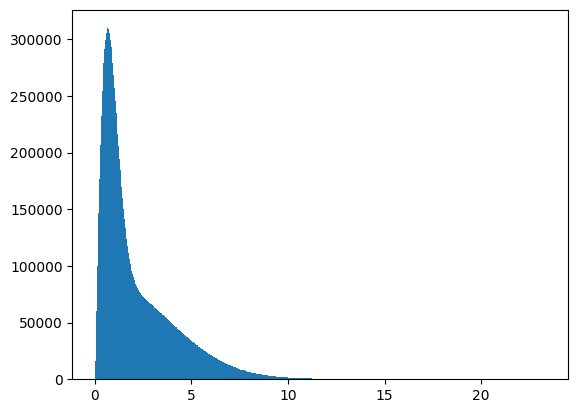

In [5]:
distances = df6d['distance'].compute()
plt.hist(distances, bins=1000)
plt.show()

## 4. Coordinate Transformations

Convert from observational coordinates (RA, Dec, parallax, proper motions, RV) 
to Galactocentric Cartesian and cylindrical coordinates.

**Note:** These transformation functions are custom-written, Astropy can also be used here!

Solar position: `r☉ = (-8.3, 0.0, 0.02) kpc`
Solar velocity: `v☉ = (11.1, 244.24, 7.24) km/s`

In [6]:
# now I want to compute galactocentric coordinates, for further masking. We will use manual coordinate conversions.

rad_to_deg = 180./np.pi      # radians to degrees
deg_to_rad = np.pi/180.      # degrees to radians
def spherical_to_cartesian_positions(phi,theta,r):
  """convert spherical coordinates to cartesian coordinates

    inputs
    -------------
    phi         : (float) azimuthal angle
    theta       : (float) polar angle
    r           : (float) radius
    
    outputs
    -------------
    array([x,y,z]) : (array of floats) cartesian coordinates
  """
  cosp,sinp,cost,sint = np.cos(phi),np.sin(phi),np.cos(theta),np.sin(theta)
  x = r*sint*cosp
  y = r*sint*sinp
  z = r*cost
  return np.array([x,y,z])

def spherical_to_cartesian_velocities(phi,theta,vr,vphi,vtheta):
  """convert spherical velocities to cartesian velocities
    
    inputs
    -------------
    phi         : (float) azimuthal angle
    theta       : (float) polar angle
    vr          : (float) radial velocity
    vphi        : (float) azimuthal velocity
    vtheta      : (float) polar velocity
    outputs
    -------------
    array([vx,vy,vz]) : (array of floats) cartesian velocities
  """
  cosp,sinp,cost,sint = np.cos(phi),np.sin(phi),np.cos(theta),np.sin(theta)
  vx = sint*cosp*vr + cost*cosp*vtheta - sinp*vphi
  vy = sint*sinp*vr + cost*sinp*vtheta + cosp*vphi
  vz = cost     *vr - sint     *vtheta
  return np.array([vx,vy,vz])

def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq. 3.57"""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)])

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    if hasattr(a,'size'):
        return np.array([-np.sin(a),np.cos(a),np.zeros(a.size)])
    else:
        return np.array([-np.sin(a),np.cos(a),0.])

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),np.cos(d)])

def return_muicrs(a,d,mua,mud):
    """ eq. 3.66, the proper motion vector"""
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    return p*mua + q*mud

def return_rgal(l,b):
    """ eq. 3.58"""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)])

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    if hasattr(l,'size'):
        return np.array([-np.sin(l),np.cos(l),0.*np.cos(l)])
    else:
        return np.array([-np.sin(l),np.cos(l),0.*np.cos(l)])

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),np.cos(b)])

def return_mugal(l,b,mul,mub):
    """ eq. 3.66, the proper motion vector"""
    p = return_pgal(l,b)
    q = return_qgal(l,b)
    return p*mul + q*mub


def rotate_velocities(a,d,mua,mud):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68

    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    p = return_pgal(ell,b)
    q = return_qgal(ell,b)

    mul = np.sum(p*mugal,axis=0)
    mub = np.sum(q*mugal,axis=0)
    return mul,mub


def rotate_galactic(a,d):
    """eq 3.68, """
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    return ell,b

def convert_obs_to_cartesian(ra,dec,dist,pmra,pmdec,radvel,\
                             sol_offset_pos = np.array([-8.3, 0., 0.02]),\
                             sol_offset_vel = np.array([11.1, 244.24, 7.25]),getall=False):
  """bring positions in degrees"""
  l,b = rotate_galactic(ra*deg_to_rad,dec*deg_to_rad)
  pl,pb = rotate_velocities(ra*deg_to_rad,dec*deg_to_rad,pmra,pmdec)
  #print(pl*dist*4.74,pb*dist*4.74)
  theta  = (np.pi/2.)-b
  phi    = l
  vr     = radvel
  vphi   = pl*dist*4.74
  vtheta = -pb*dist*4.74
  x0    = (spherical_to_cartesian_positions(phi,theta,dist))
  v0    = (spherical_to_cartesian_velocities(phi,theta,vr,vphi,vtheta))
  #x0 has shape 3,1,Nstars and v0 has shape 3,1,Nstars, reshape to 3,Nstars
  x0 = x0.reshape(3,-1)
  v0 = v0.reshape(3,-1)
  x0 = x0.T+sol_offset_pos
  v0 = v0.T+sol_offset_vel
  if getall:
    return x0,v0,l,b, pl, pb
  else:
    return x0,v0

#in order to apply conversions to the dask df, we need to map the functions to the partitions
def apply_galactocentric_conversion(partition):
    """Apply coordinate conversion to each partition"""
    # Extract arrays
    ra = partition['ra'].values
    dec = partition['dec'].values
    dist = partition['distance'].values
    pmra = partition['pmra'].values
    pmdec = partition['pmdec'].values
    rv = partition['radial_velocity'].values
    
    # Apply conversion
    x0, v0, l, b, pl, pb = convert_obs_to_cartesian(
        ra, dec, dist, pmra, pmdec, rv, getall=True
    )
    
    # Add new columns to partition
    partition = partition.assign(
        x_gal=x0[:, 0],
        y_gal=x0[:, 1],
        z_gal=x0[:, 2],
        vx_gal=v0[:, 0],
        vy_gal=v0[:, 1],
        vz_gal=v0[:, 2],
        l_gal=l * rad_to_deg,
        b_gal=b * rad_to_deg,
        pmra_gal=pl,
        pmdec_gal=pb
    )
    
    return partition

def get_azimuthal_difference(p1, p2):
    """
    Compute the (minimum) azimuthal difference between two azimuths, p1-p2.
    This function calculates the smallest angular difference (in radians)
    between  two azimuthal coordinates p1 and p0. It handles arbitrary
    angular coordinates by wrapping them within the [0, 2π] range, and computes
    the smallest angular difference, accounting for the periodicity of the
    circle.
    Parameters
    ----------
    p1 : float or array_like
        The first azimuthal coordinate(s) in radians.
    p2 : float or array_like
        The second azimuthal coordinate(s) in radians.
    Returns
    -------
    difference : float or ndarray
        The minimum azimuthal difference between p1 and p2, in radians. The
        output is wrapped within the range [-π, π]. If p1 and p0 are
        scalars, a scalar is returned. If arrays are provided, an array of the
        same shape as the inputs is returned.
    """
    # cast to numpy arrays
    p1 = np.atleast_1d(p1)
    p2 = np.atleast_1d(p2)
    # 2pi modulus
    p1 = np.mod(p1, 2 * np.pi)
    p2 = np.mod(p2, 2 * np.pi)
    # get azimuthal differences including +1 and -1 2pi wrap
    dp = np.stack((p1 - 2 * np.pi - p2, p1 - p2, p1 + 2 * np.pi - p2), axis=-1)
    # find (abs-)minimum of 3 differences
    inds = np.argmin(np.abs(dp), axis=1)
    dp = dp[np.arange(len(dp)), inds]
    # if only one, recast to scalar
    if dp.size == 1:
        dp = dp.item()
    return dp

def get_cylindrical_am(partition):
    x = partition['x_gal'].values
    y = partition['y_gal'].values
    z = partition['z_gal'].values
    vx = partition['vx_gal'].values
    vy = partition['vy_gal'].values
    vz = partition['vz_gal'].values
    R = np.sqrt(x**2. + y**2.)
    phi = partition['phi_gal'].values
    vR = vx *np.cos(phi) + vy*np.sin(phi)
    vphi = -vx*np.sin(phi) + vy*np.cos(phi)

    Lx = y * vz - z * vy
    Ly = z * vx - x * vz
    LR = -z * vphi
    Lphi = z * vR -R * vz
    Lz = R * vphi

    # Add new columns to partition
    partition = partition.assign(
        LR=LR,
        Lphi=Lphi,
        Lz=Lz,
        vr_gal=vR,
        vphi_gal=vphi
    )
    return partition



## 5. Calculate Angular Momentum

Compute angular momentum components:
- Cartesian: Lx, Ly, Lz
- Cylindrical: LR, Lφ, Lz

These calculations are applied to all 26M stars using Dask's `map_partitions` for parallel processing.

In [7]:
# Apply the transformation
df6d = df6d.map_partitions(apply_galactocentric_conversion, meta=df6d._meta.assign(
    distance=0.0,
    x_gal=0.0, y_gal=0.0, z_gal=0.0,
    vx_gal=0.0, vy_gal=0.0, vz_gal=0.0,
    l_gal=0.0, b_gal=0.0,
    pmra_gal=0.0, pmdec_gal=0.0
))
# Calculate cylindrical galactocentric coordinates
df6d = df6d.assign(
    R_gal=np.sqrt(df6d['x_gal']**2 + df6d['y_gal']**2),  # Galactocentric radius in kpc
    phi_gal=np.arctan2(df6d['y_gal'], df6d['x_gal'])  # Azimuth in radians
)

# Calculate cylindrical galactocentric AM coordinates
df6d = df6d.map_partitions(get_cylindrical_am, meta=df6d._meta.assign(
    LR=0.0, Lphi=0.0, Lz=0.0, vr_gal=0.0, vphi_gal=0.0
))



In [8]:
df6d.head(10)

source_id         ra        dec       pmra  pmra_error  \
35    3603550576342528  46.814305   4.791710   2.600219    0.031093   
37    3829427200867968  46.510951   5.239562 -26.790393    0.018637   
57    6334806179264896  42.840291   5.482269  -2.025342    0.024697   
60    6508937037748096  41.465991   5.950228  -1.617860    0.020234   
109  12617999736082560  52.117323   9.535283   3.264631    0.022735   
113  13455930675675392  53.266736  11.442793   3.177231    0.019130   
120  14534787804999040  49.584623  10.051462   2.151012    0.018021   
174  21071148209458176  43.854084   9.698150 -10.399513    0.035365   
184  22756111124289536  36.947507   8.434952 -24.130968    0.049893   
186  23158089998528000  37.654659   8.870822  36.022746    0.035093   

         pmdec  pmdec_error  pmra_pmdec_corr  parallax  parallax_over_error  \
35   -3.284672     0.027092         0.332688  0.639692            23.612848   
37  -28.229365     0.014781         0.133427  4.498183           241.490982   
57  -10.489685     0.021549         0.153383  1.617399            79.990593   
60   -3.720117     0.019061         0.291807  1.409949            74.475388   
109  -0.654701     0.016743         0.152535  0.296626            14.869323   
113  -6.977854     0.014613         0.151874  2.557576           172.047165   
120   4.725003     0.014889         0.061509  0.898230            57.365730   
174  -5.348042     0.029295         0.178646  3.312745           115.109489   
184 -73.192674     0.047713         0.350839  6.207781           148.661865   
186 -24.524343     0.032355         0.314160  2.217928            71.784698   

     ...      b_gal   pmra_gal  pmdec_gal      R_gal   phi_gal          LR  \
35   ... -44.231217   4.151460  -0.561771   9.414527  3.128946 -232.099886   
37   ... -44.115827  -0.077077 -38.918071   8.458492  3.139346  -31.878355   
57   ... -46.370059   5.212587  -9.325473   8.719234  3.132308  -95.917295   
60   ... -46.875245   1.053886  -3.917405   8.773245  3.129245 -119.136692   
109  ... -37.161670   2.772444   1.843911  10.977230  3.118030 -409.241719   
113  ... -35.012449   7.170324  -2.715085   8.618433  3.137581  -46.543530   
120  ... -38.521225  -1.637362   4.926616   9.162852  3.127945 -174.461074   
174  ... -42.469303  -4.825840 -10.651886   8.516598  3.135451  -45.525551   
184  ... -47.460564  18.970946 -74.696549   8.402165  3.137074  -20.637426   
186  ... -46.715843  43.567842  -0.961669   8.591337  3.129354  -50.687917   

           Lphi           Lz     vr_gal    vphi_gal  
35   258.908526 -2041.289647  27.689857 -216.823399  
37  -113.861816 -2001.002297 -76.684278 -236.567272  
57    45.713737 -1956.245472 -33.013534 -224.359783  
60    46.071562 -2100.281427 -14.267458 -239.396189  
109 -246.890283 -2227.841218  34.915932 -202.951130  
113 -192.095194 -1963.109066 -40.164354 -227.780274  
120  -51.485127 -2373.976125  38.010343 -259.087033  
174    4.551040 -2109.282313 -25.459958 -247.667243  
184   80.438619 -1756.976878 -63.833686 -209.110029  
186  172.523090 -1412.889325  45.586385 -164.455115  

[10 rows x 31 columns]

## 6. Apply Spatial Cut (in Galactocentric coords)

Select stars in the solar neighborhood:
- Radial: `|R - 8.3 kpc| < 1.0 kpc`
- Azimuthal: `|φ - π| < 1.0/8.3` rad (~7°)

In [10]:
# Define the target azimuth (180 degrees = pi radians, anti-center direction)
phi_target = np.pi  # radians

# Azimuthal tolerance
phi_tolerance = 1.0 / 8.3  # radians ~ 7 degrees

# Apply the azimuthal difference function using map_partitions
def apply_azimuthal_mask(partition):
    """Apply azimuthal difference calculation to each partition"""
    phi_diff = get_azimuthal_difference(partition['phi_gal'].values, phi_target)
    partition = partition.assign(phi_diff=np.abs(phi_diff))
    return partition

# Add the phi_diff column
df6d = df6d.map_partitions(
    apply_azimuthal_mask, 
    meta=df6d._meta.assign(phi_diff=0.0)
)

# Apply the spatial cuts
df6dlocal = df6d[
    (np.abs(df6d['R_gal'] - 8.3) < 1.0) &
    (df6d['phi_diff'] < phi_tolerance)
]


print(df6dlocal.shape[0].compute())

11827676


## 7. Visualize the Spiral

    -Create 2D histogram of LR vs Lφ to see the spiral structure - Same as figure 1 in Yaaqib et al (2025).
    -Create also 2D histogram of LR vs Lφ binned in Lz, to see changing spiral morphology.

In [11]:
#Now that the dataframe is created with the required coordinates, let plot the z-vz spiral
import dask.array as da

# set up L grid
lim = 500
N_bins = 128
edges = np.linspace(-lim, lim, N_bins + 1)
L1_grid, L2_grid = np.meshgrid(edges, edges, indexing='ij')

f, _, _ = np.histogram2d(
    df6dlocal['LR'].compute(),
    df6dlocal['Lphi'].compute(),
    bins=edges,
    density=True)

#symmetrize the histrogram
f_sm = 0.5 * (f + np.fliplr(np.flipud(f)))
#compute fractional residual
res = (f - f_sm) / f_sm

# set up L grid
limz = 5
N_binsz = 128
edgesz = np.linspace(-limz, limz, N_binsz + 1)
Z1_grid, Z2_grid = np.meshgrid(edgesz, edgesz, indexing='ij')

fzvz, _, _ = np.histogram2d(
    df6dlocal['z_gal'].compute()/df6dlocal['z_gal'].std().compute(),
    df6dlocal['vz_gal'].compute()/df6dlocal['vz_gal'].std().compute(),
    bins=edgesz,
    density=True)

#symmetrize the histrogram
fzvz_sm = 0.5 * (fzvz + np.fliplr(np.flipud(fzvz)))
#compute fractional residual
reszvz = (fzvz - fzvz_sm) / fzvz_sm



Text(0, 0.5, '$v_z\\ [\\mathrm{km/s}]$')

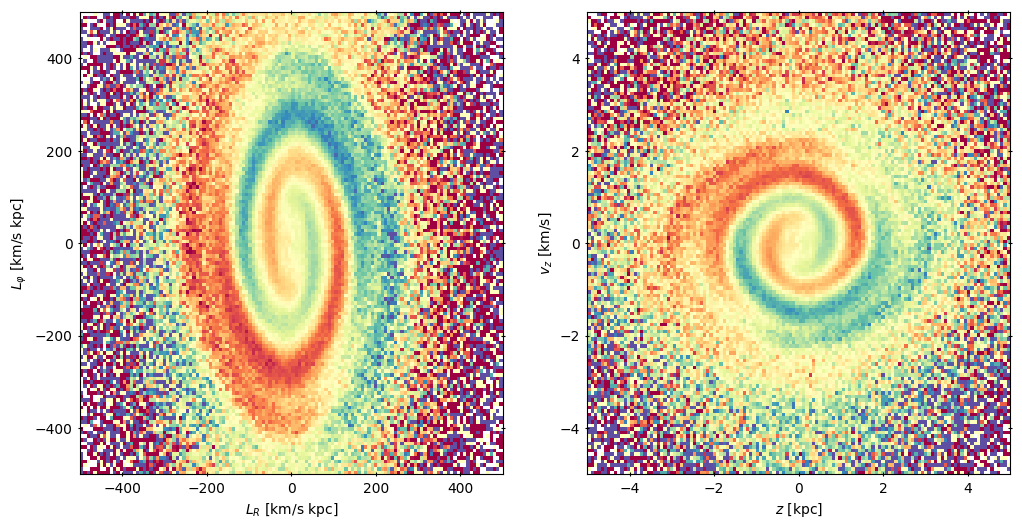

In [12]:
#plotting stars here
pargs = dict(cmap='Spectral', vmin=-0.3, vmax=0.3, rasterized=True)

fig, ax = plt.subplots(1,2,figsize=(12,6))
pcmAM = ax[0].pcolormesh(L1_grid,L2_grid, res, **pargs)
pcmZVZ = ax[1].pcolormesh(Z1_grid,Z2_grid, reszvz, **pargs)
ax[0].tick_params(top=True,right=True,direction='inout')
ax[1].tick_params(top=True,right=True,direction='inout')

ax[0].set_xlabel(r'$L_R\ [\mathrm{km/s~kpc}]$')
ax[0].set_ylabel(r'$L_\varphi\ [\mathrm{km/s~kpc}]$')

ax[1].set_xlabel(r'$z\ [\mathrm{kpc}]$')
ax[1].set_ylabel(r'$v_z\ [\mathrm{km/s}]$')

In [13]:
# set up L grid
lim = 500
N_bins = 64
edges = np.linspace(-lim, lim, N_bins + 1)
L1_grid, L2_grid = np.meshgrid(edges, edges, indexing='ij')

# construct Lz bins
N_Lz_bins = 8
Lz_min = -2500
Lz_max = -1100
Lz_edges = np.linspace(Lz_min, Lz_max, N_Lz_bins + 1)
Lz_bin_inds = np.digitize(df6dlocal['Lz'].compute(), Lz_edges) - 1



In [14]:

rRphi_list = []
for i in range(N_Lz_bins):
    m = Lz_bin_inds == i
    
    fRphi = np.histogram2d(df6dlocal['LR'].compute()[m], df6dlocal['Lphi'].compute()[m], bins=edges, density=True)[0]

    # residuals against smooth models
    fRphi_sm = 0.5 * (fRphi + np.fliplr(np.flipud(fRphi)))
    rRphi = (fRphi - fRphi_sm) / fRphi_sm
    rRphi_list.append(rRphi)


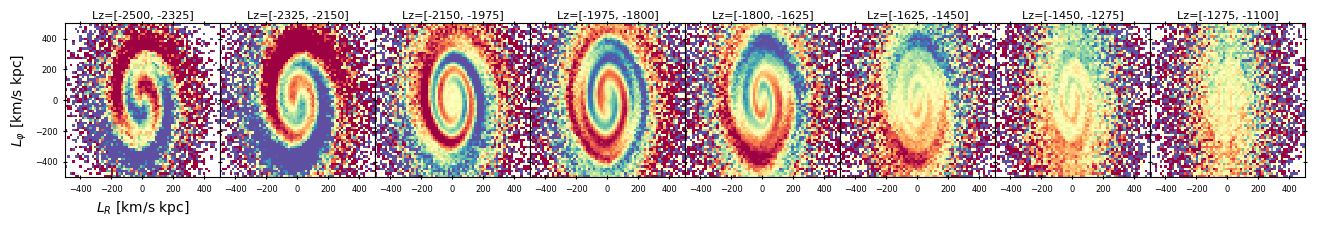

In [15]:
fig, ax = plt.subplots(1,8,figsize=(16,2),sharey=True)
args1 = dict(cmap='Spectral', vmin=-0.3, vmax=0.3, rasterized=True)


for i, a in enumerate(ax):
    a.tick_params(top=True, right=True, direction='inout',labelsize=6)
    a.set_xticks([-400, -200, 0, 200, 400])
    a.set_yticks([-400, -200, 0, 200, 400])
ax[0].set_xlabel(r'$L_R\ [\mathrm{km/s~kpc}]$')
ax[0].set_ylabel(r'$L_\varphi\ [\mathrm{km/s~kpc}]$')



for i in range(N_Lz_bins):
    pcm = ax[i].pcolormesh(L1_grid, L2_grid, rRphi_list[i], **args1)
    lb = int(Lz_edges[i])
    ub = int(Lz_edges[i + 1])
    ax[i].set_title(f'Lz=[{lb}, {ub}]', va='center', ha='center', fontsize=8)
plt.subplots_adjust(wspace=0.0)


## 8. Orbit Integration with GALA

To understand the physics, we integrate orbits of example stars.
GALA must be pip installed via `%pip install gala`

In [16]:
%pip install gala galpy

Note: you may need to restart the kernel to use updated packages.


In [17]:
import gala.potential as gp
import gala.dynamics as gd
import astropy.units as u
potential = gp.MilkyWayPotential()

In [18]:
sample = df6dlocal.sample(frac=0.0001)
sample.shape[0].compute()

1193

In [19]:
# set initial velocity and position 
init_pos = np.c_[sample['x_gal'].compute(), sample['y_gal'].compute(), sample['z_gal'].compute()]
init_vel = np.c_[sample['vx_gal'].compute(), sample['vy_gal'].compute(), sample['vz_gal'].compute()]

In [20]:
w0 = gd.PhaseSpacePosition(pos=init_pos.T * u.kpc, vel = init_vel.T * u.km/u.s)

In [21]:
# lets integrate for 500 Myr
t_total = 0.5e9
n_steps=5000

orbit = potential.integrate_orbit(w0, dt=(t_total/n_steps) * u.yr, n_steps=n_steps)

In [22]:
# get np arrays of PS coords
t = orbit.t.to_value(u.Gyr)
x = orbit.x.to_value(u.kpc)
y = orbit.y.to_value(u.kpc)
z = orbit.z.to_value(u.kpc)
vx = orbit.v_x.to_value(u.km/u.s)
vy = orbit.v_y.to_value(u.km/u.s)
vz = orbit.v_z.to_value(u.km/u.s)

# cylindricals
phi = np.arctan2(y, x)
R = np.sqrt(x**2 + y**2)
vR = vx * np.cos(phi) + vy * np.sin(phi)
vphi = -vx * np.sin(phi) + vy * np.cos(phi)
LR = - z * vphi
Lphi = z * vR - R * vz
Lz = R * vphi

In [23]:
select = np.where((R[0,:] >7.7) & (R[0,:]<8.2) )[0]# & (vR[0,:] < 50) & (np.min(R, axis=0) >7.5)& (np.max(R, axis=0) <8.5))[0]
print(select.shape)
select = np.random.choice(select, size=5,replace=False)
print(select.shape, select)

(388,)
(5,) [823 782 173 137 146]


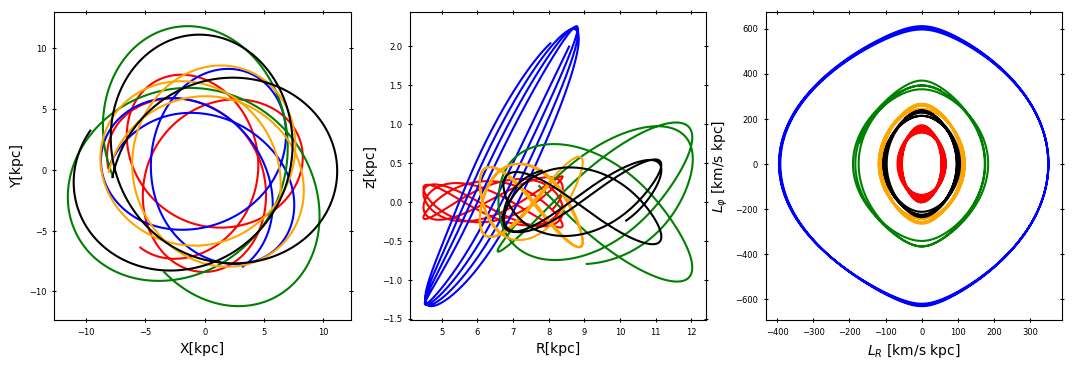

In [24]:
# now lets visualise these orbits

fig, ax = plt.subplots(1,3,figsize=(13,4))
colours = plt.cm.viridis(np.linspace(0,1,len(R[0,:]+1)))
colours = ['r','b','g','orange','k','magenta','teal', 'violet', 'deeppink','olive']
# colours = colours[np.argsort(np.sqrt(np.mean(LR**2, axis=0) + np.mean(Lphi**2, axis=0)))]
# colours = colours[np.random.choice(np.arange(0,len(R[0,:])),size=10)]
for i in range(len(select)):
    ax[0].plot(x[:,select[i]],y[:,select[i]], color=colours[i])
    ax[1].plot(R[:,select[i]], z[:,select[i]], color=colours[i])
    ax[2].plot(LR[:,select[i]],Lphi[:,select[i]],color=colours[i])
for i, a in enumerate(ax):
    a.tick_params(top=True, right=True, direction='inout',labelsize=6)

ax[0].set_xlabel("X[kpc]")
ax[0].set_ylabel("Y[kpc]")

ax[1].set_xlabel("R[kpc]")
ax[1].set_ylabel("z[kpc]")

ax[2].set_xlabel(r'$L_R\ [\mathrm{km/s~kpc}]$')
ax[2].set_ylabel(r'$L_\varphi\ [\mathrm{km/s~kpc}]$')


plt.show()
